# Define PANORAMIC fields

The associations have been computed in `step1-define-associations.ipynb` and the preprocessing executed elsewhere....


In [1]:
import os
os.chdir('../Mosaics')

In [2]:
! head -1 panoramic_fields.txt
! cat panoramic_fields.txt | sort -k 9

# field        n   sx    sy   ra         dec         nx  ny  date       time
j170720p5853 120   4.9   6.9 256.841500   58.879350  4   6  2023-02-18 00:03:56.209
j153500p2325 240   3.6   6.4 233.742500   23.420000  3   5  2023-03-06 09:39:23.999
j145652p2444  40   5.3   6.7 224.223500   24.740000  4   5  2023-03-24 02:33:18.312
j123800p6217 432  17.0  15.7 189.485500   62.249400 13  12  2023-03-28 07:25:57.468
j125652p5652 240   6.4   3.8 194.211500   56.865700  5   3  2023-04-01 19:15:23.999
j090000p0207  80   4.0   6.5 135.004000    2.114070  3   5  2023-04-03 09:42:05.050
j150604p5409 160   6.5   7.1 226.514500   54.154800  5   6  2023-04-03 14:28:49.893
j093452p6116  80   5.9   6.5 143.708500   61.272400  5   5  2023-04-06 19:16:17.682
j094232p0923 120   4.9   6.7 145.630000    9.378995  4   5  2023-04-19 09:41:11.366
j093144p0819 120   4.7   6.7 142.941000    8.325030  4   5  2023-04-20 04:53:11.366
j100736p2109  60   5.2   6.7 151.906000   21.155250  4   5  2023-05-07 07:21:18.312

In [3]:
# Which mosaics hae been made?
! cat mosaic_log.txt

# field  version date time
j090000p0207  v6.0  2023-05-04 09:44:57.191
j145652p2444  v6.0  2023-05-04 10:37:56.604
j093144p0819  v6.0  2023-05-04 11:16:46.528
j100736p2109  v6.0  2023-05-10 16:07:03.162
j093452p6116  v6.0  2023-05-10 18:43:31.732
j125652p5652  v6.0  2023-05-10 18:44:39.470
j150604p5409  v6.0  2023-05-10 19:45:12.123
j170720p5853  v6.0  2023-05-10 20:00:33.283
j094232p0923  v6.0  2023-05-10 20:12:52.988
j153500p2325  v6.0  2023-05-10 22:13:33.482
j131432p2432  v6.0  2023-06-13 13:57:40.377
j134348p5549  v6.0  2023-06-13 14:20:56.488
j121932p0330  v6.0  2023-06-14 13:06:03.030
j142536p5630  v6.0  2023-06-29 19:20:17.000
j130016p1215  v6.0  2023-06-29 20:56:29.000
j144904m1017  v6.0  2023-07-04 17:49:08.950
j123140m1618  v6.0  2023-07-04 18:35:28.420 
j000352m1120  v6.0  2023-07-19 21:19:40.026
j043844m6849  v6.0  2023-08-01 17:44:07.158
j021824m0517  v6.0  2023-08-01 18:12:07.183
j234512m4235  v6.0  2023-08-01 21:22:38.265
j010408m5508  v6.0  2023-08-07 22:03:14.504
j021

In [4]:
import os
import gc
import glob

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
import astropy.wcs as pywcs
import astropy.time

from grizli.aws import db, visit_processor
from grizli import utils, prep
from grizli.pipeline import auto_script

from mastquery import overlaps

Set ROOT_PATH=/usr/local/share/python/panoramic-jwst/Mosaics


In [5]:
def create_s3_index(path, output_file="index.html", extra_html="", upload=True):
    """
    Create HTML listing of an S3 path
    """
    import time

    url = path.replace('s3://', 'https://s3.amazonaws.com/')

    lsfile = output_file.replace('.html','.ls')

    # Sort by filename
    sort_str = 'sort -k 4'

    os.system(f'aws s3 ls {path} | {sort_str} |grep -v PRE |grep -v {output_file} > {lsfile}')

    now = time.ctime()
    html=f"<h3>{now}</h3>\n"

    html += extra_html

    html += "\n<pre>\n"
    
    lines=open(lsfile).readlines()
    for line in lines:
        lsp = line.split()
        if len(lsp) == 4:
            html += "{0} {1} {2:>10} <a href={4}{3} > {3} </a>\n".format(*lsp, url)

    html += '</pre>\n'
    fp = open(output_file,'w')
    fp.write(html)
    fp.close()
    
    if upload:
        os.system(f'aws s3 cp {output_file} {path} --acl public-read')
        print(path.replace('s3://', 'https://s3.amazonaws.com/') + output_file)

    print(output_file)


## Query database for exposure footprints

In [6]:
# Query the grizli database for processed exposures
program_id = 2514 # Panoramic

res = db.SQL(f"""select assoc, dataset, filter,
crval1 as ra, crval2 as dec, footprint as coords,
expstart as t_min, exptime, detector, instrume
from exposure_files where (dataset like 'jw{program_id:05d}%%')
""")

len(res)


5365

In [7]:
# Compute general footprint for a given field based on NIRCam overlaps
if 0:
    # e.g., MACS0416
    
    ra, dec = 93.968, -57.781

    res = db.SQL(f"""select assoc, dataset, filter,
crval1 as ra, crval2 as dec, footprint as coords,
expstart as t_min, exptime, detector, instrume
from exposure_files where polygon(footprint) && polygon(circle(point({ra}, {dec}),0.5)) and instrume = 'NIRCAM'
""")
    
    res['parent'] = [a.split('_')[0] for a in res['assoc']]
    un = utils.Unique(res['parent'])
    res['parent'] = un.values[np.argmax(un.counts)]
    un = utils.Unique(res['parent'])
    

In [41]:
# Group by "parent" defined when associations were generated
res['parent'] = [a.split('_')[0] for a in res['assoc']]
res['parent-filt'] = [a.split('_')[0] + '-' + f
                      for a, f in zip(res['assoc'], res['filter'])]
       
# Split double field j224612m0527
test = res['parent'] == 'j224612m0527'
south = (res['dec'] < -5.4)
print((test & south).sum(), (test & ~south).sum())

parent = res['parent'].tolist()

for i in np.where(test & south)[0]:
    parent[i]= utils.radec_to_targname(res['ra'][test & south].mean(), res['dec'][test & south].mean())
for i in np.where(test & ~south)[0]:
    parent[i]= utils.radec_to_targname(res['ra'][test & ~south].mean(), res['dec'][test & ~south].mean())
    
res['parent'] = parent

# Merge MACS0416
dr = np.sqrt((res['ra']-64.061150)**2 +  (res['dec'] + 24.144900)**2)
macs0416 = dr < 0.4
if macs0416.sum() >  0:
    print(f"Merge {np.unique(res['parent'][macs0416]).tolist()} > 'j041616m2409'")
    res['parent'][macs0416] = 'j041616m2409'
    
un = utils.Unique(res['parent'])

430 180
Merge ['j041616m2409', 'j041624m2411'] > 'j041616m2409'
   N  value     
====  ==========
   9  j123816p6217
  40  j145652p2444
  60  j100736p2109
  60  j130016p1215
  60  j043844m6849
  70  j141932p5254
  70  j021824m0517
  80  j093452p6116
  80  j090000p0207
  80  j234512m4235
  90  j024000m0142
 120  j000352m1120
 120  j170720p5853
 120  j010408m5508
 120  j144904m1017
 120  j093144p0819
 120  j142536p5630
 120  j094232p0923
 120  j134348p5549
 120  j121932p0330
 120  j123140m1618
 120  j131432p2432
 120  j013444m1532
 142  j033236m2755
 160  j150604p5409
 172  j013900m1019
 180  j014428p1715
 180  j224604m0518
 200  j010500p0217
 240  j021728m0214
 240  j153500p2325
 240  j125652p5652
 280  j021744m0518
 330  j041616m2409
 430  j224616m0531
 432  j123800p6217


In [11]:
! rm panoramic_fields.txt

# field        n   sx    sy   ra         dec         nx  ny  date       time
j000352m1120 120   4.9   6.7   0.960429  -11.326800  4   5  2023-07-14 02:29:11.366
j010408m5508 120   4.5   6.7  16.039400  -55.141650  4   5  2023-08-05 09:39:56.209
j010500p0217 200   5.2   7.0  16.245050    2.282490  4   6  2023-08-18 02:50:29.040
j013444m1532 120   4.0   6.6  23.687100  -15.531200  3   5  2023-08-14 00:03:56.209
j013900m1019 172   4.9   7.9  24.743100  -10.320000  4   6  2023-08-23 09:52:27.783
j014428p1715 180   5.5   7.8  26.108450   17.240550  5   6  2023-08-29 19:27:44.836
j021728m0214 240   4.7   6.7  34.363000   -2.228235  4   5  2023-08-06 21:43:52.418
j021744m0518 280  15.0  12.2  34.410200   -5.308470 11   9  2023-08-20 09:49:57.468
j021824m0517  70   4.6   6.7  34.598750   -5.278195  4   5  2023-07-23 07:25:57.468
j024000m0142  90   3.8   6.9  40.007250   -1.691670  3   6  2023-09-05 05:02:40.415
j033236m2755 142   3.6   6.3  53.156800  -27.912200  3   5  2023-09-03 06:19:37.230

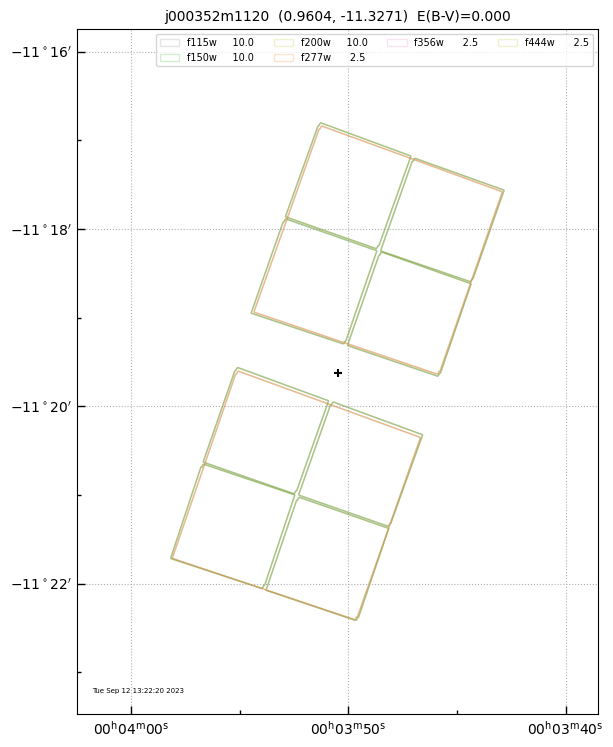

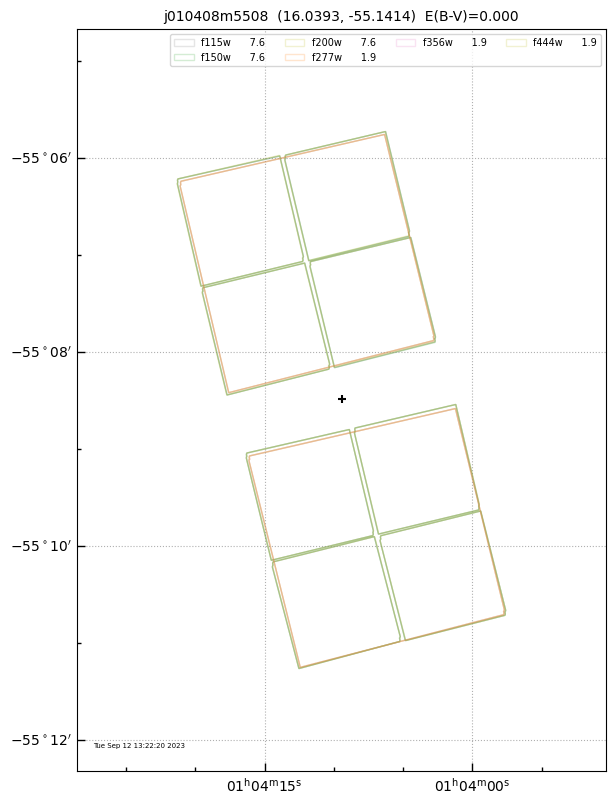

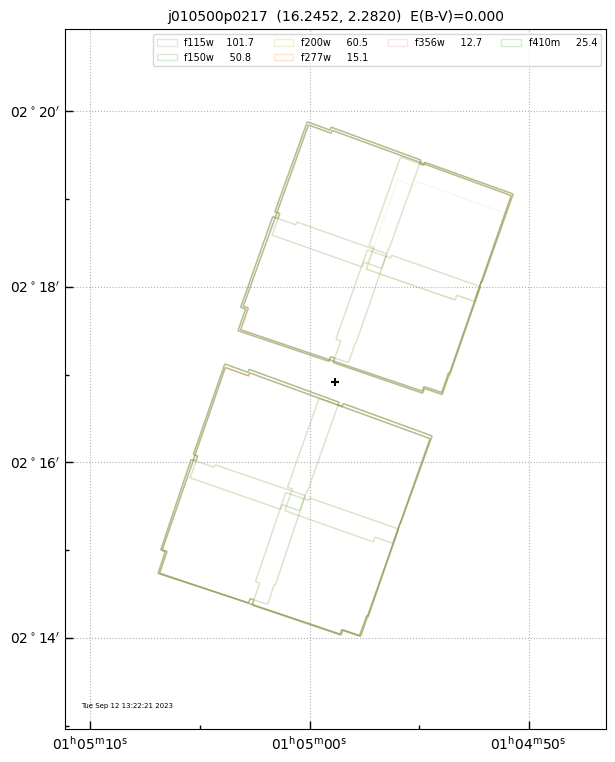

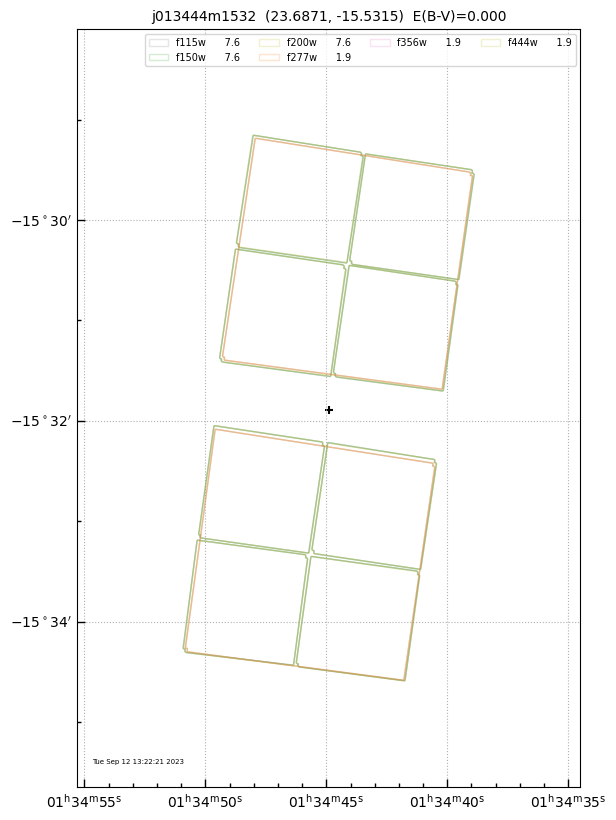

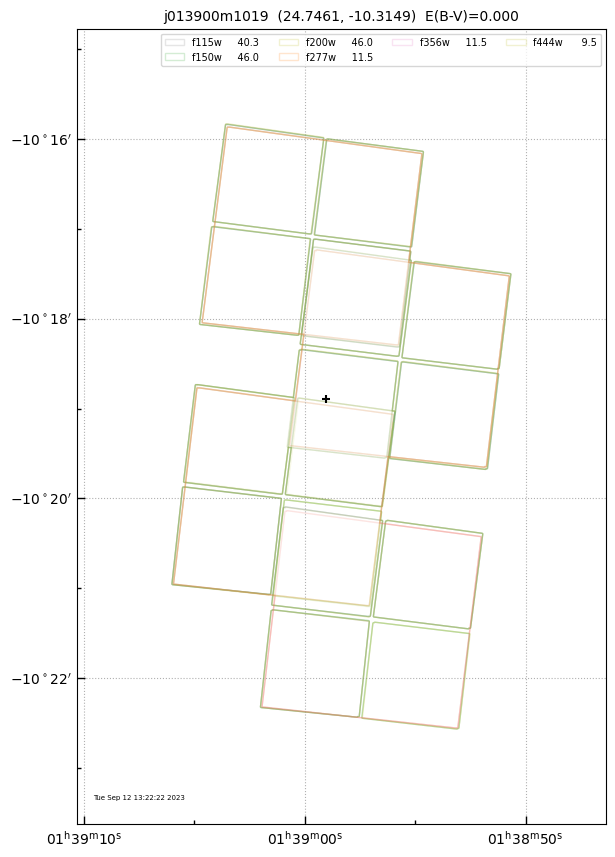

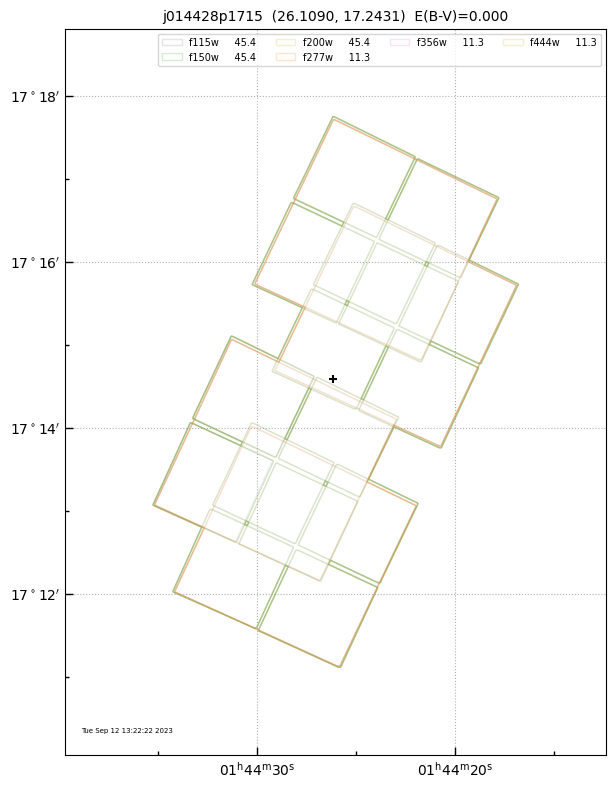

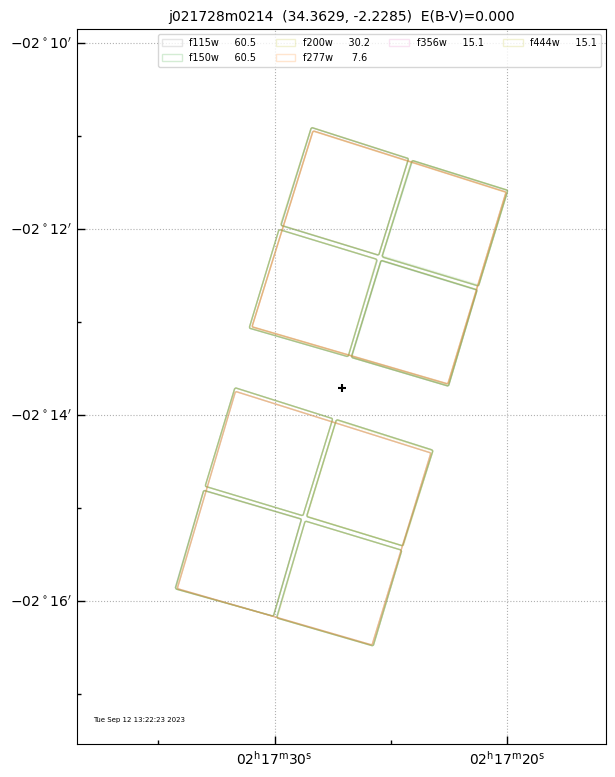

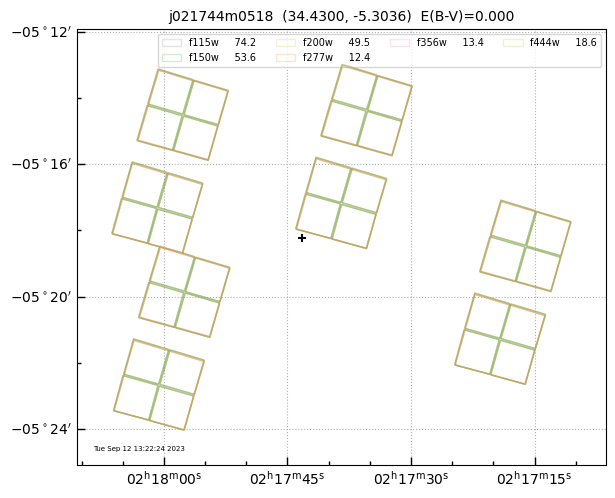

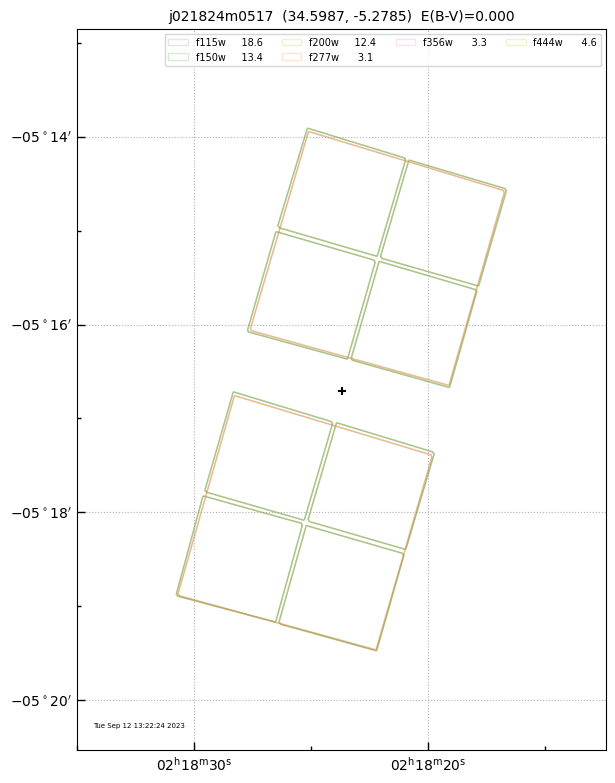

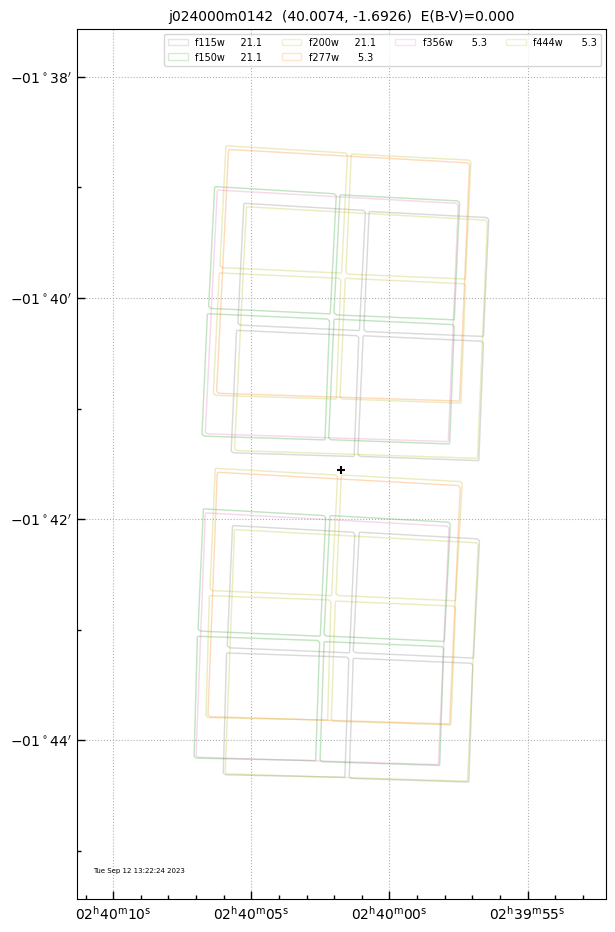

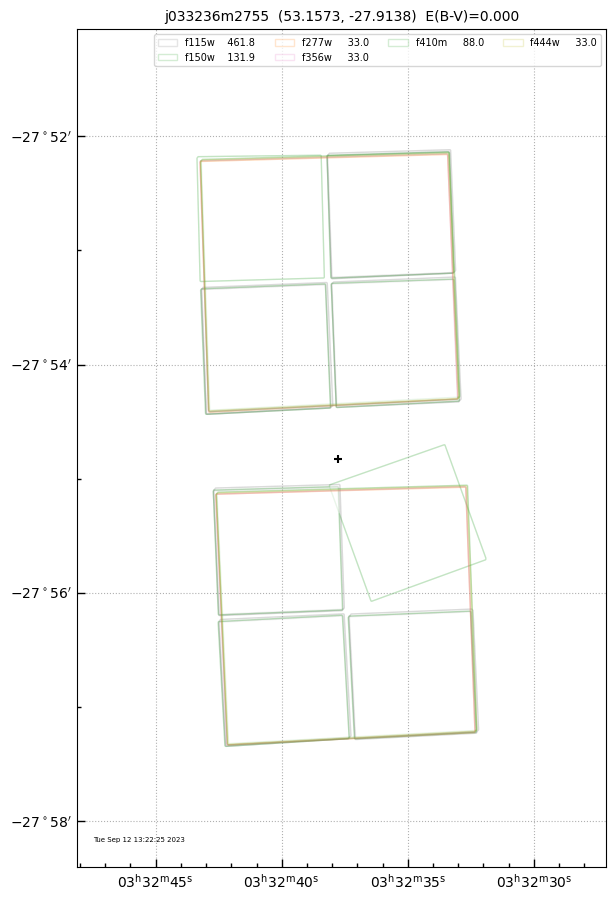

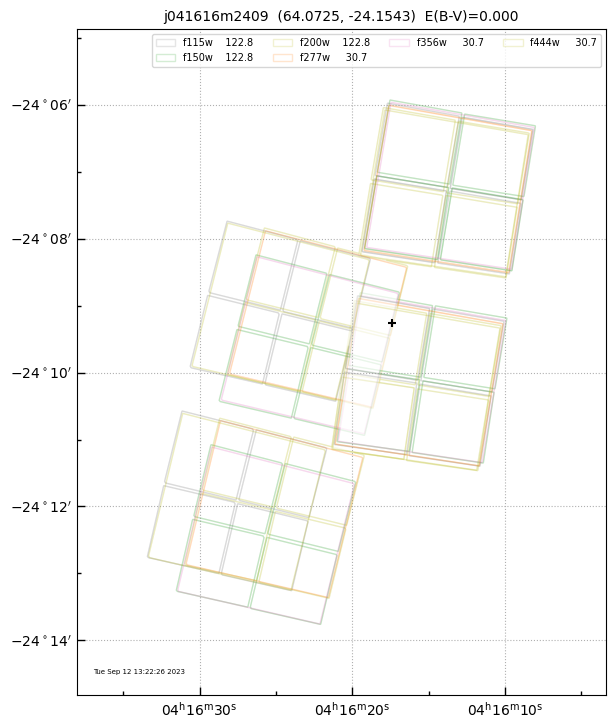

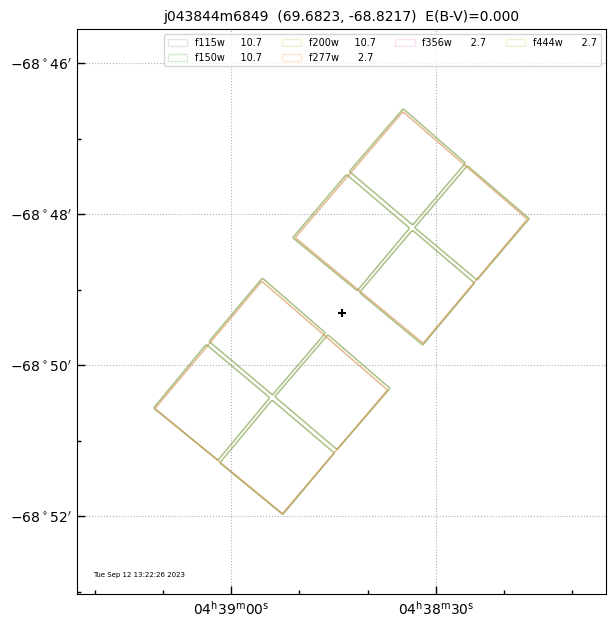

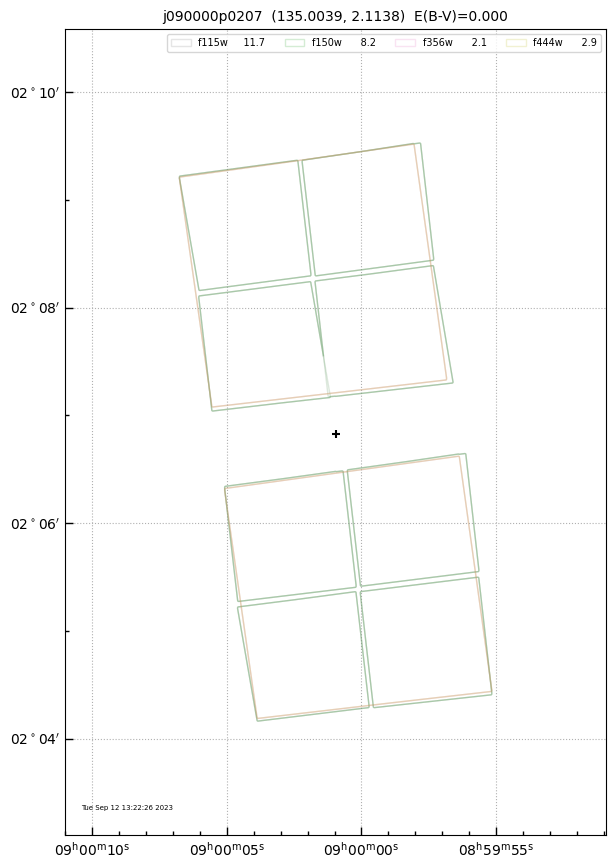

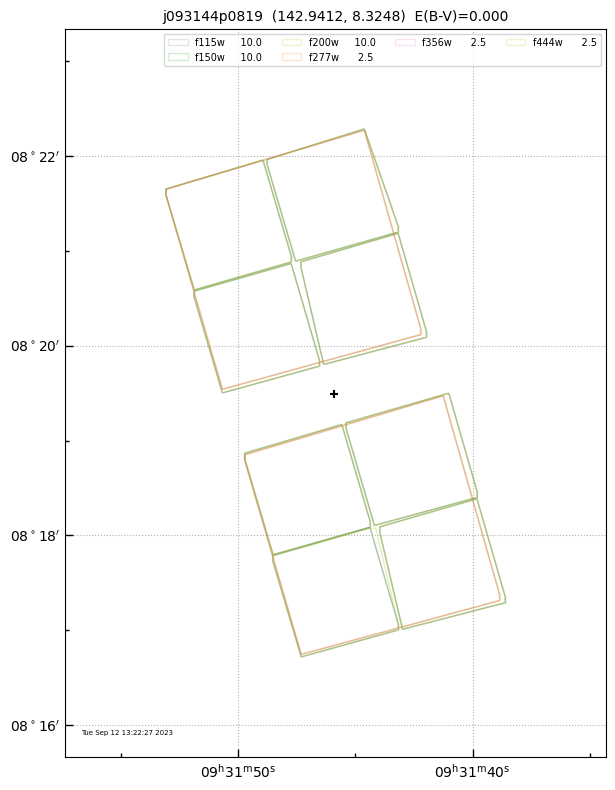

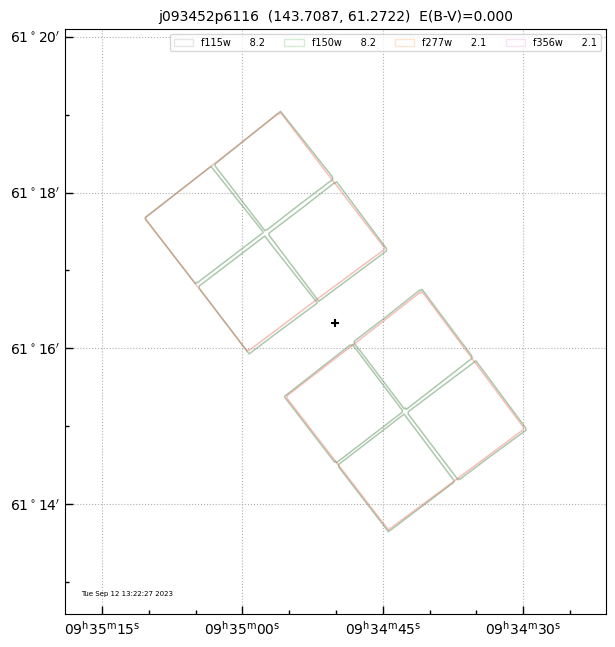

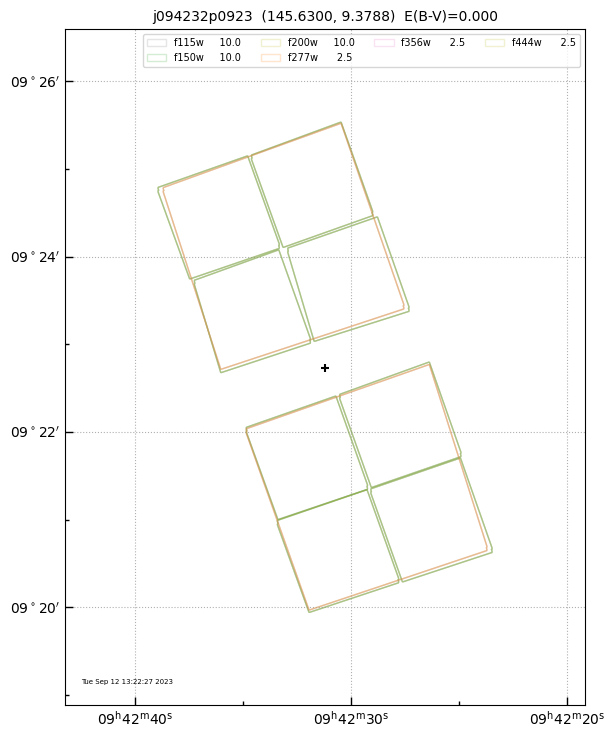

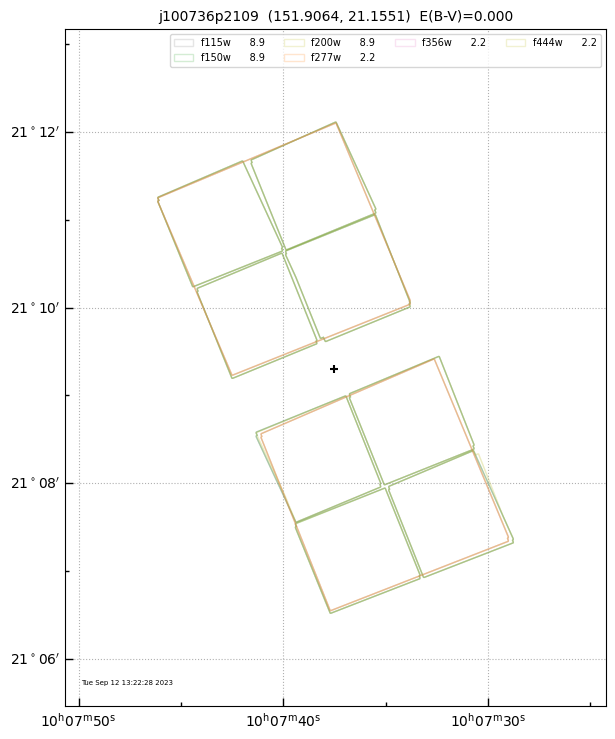

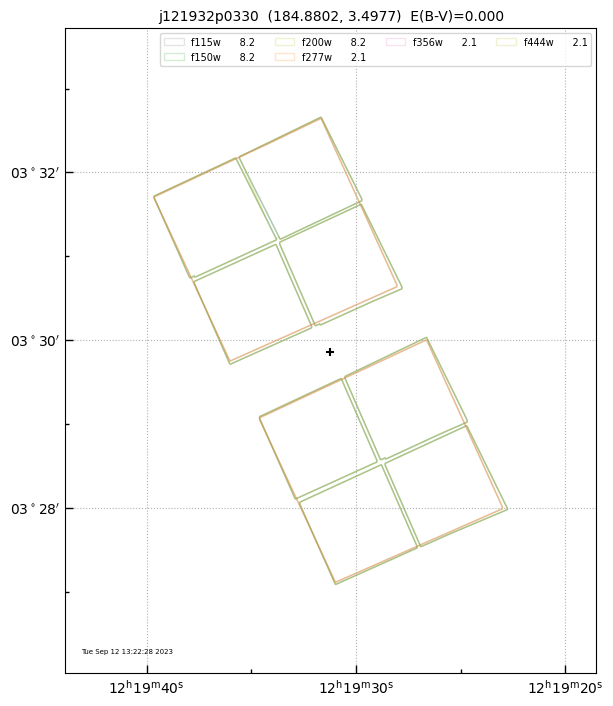

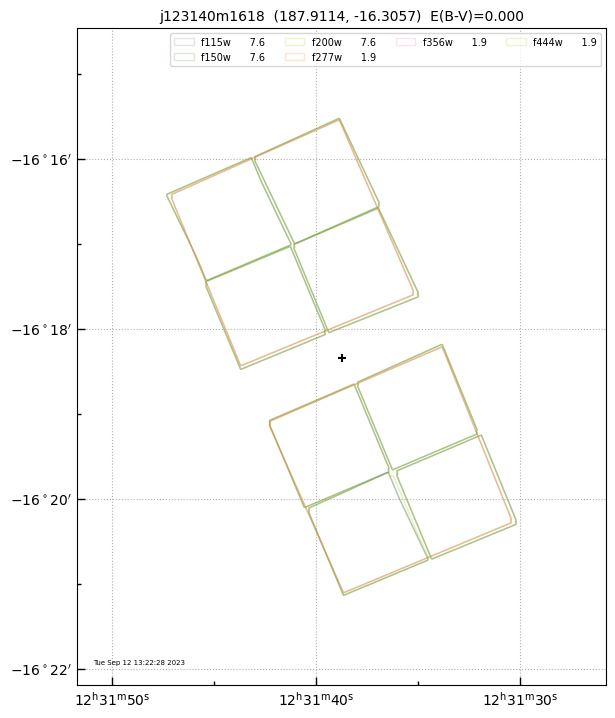

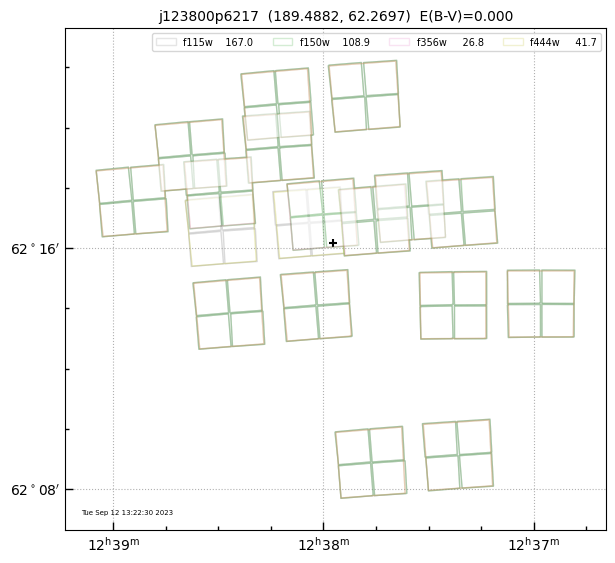

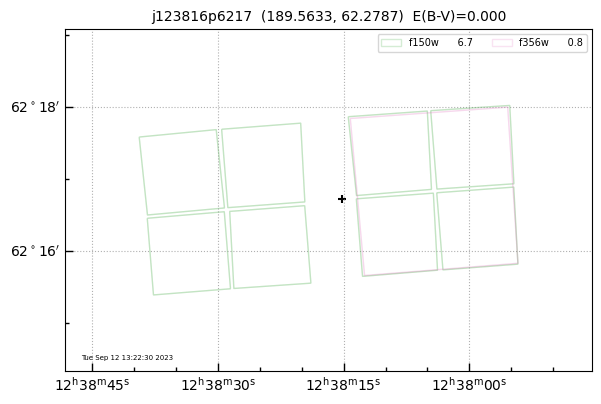

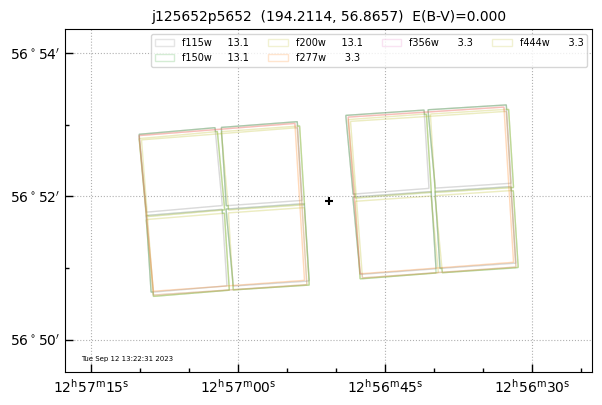

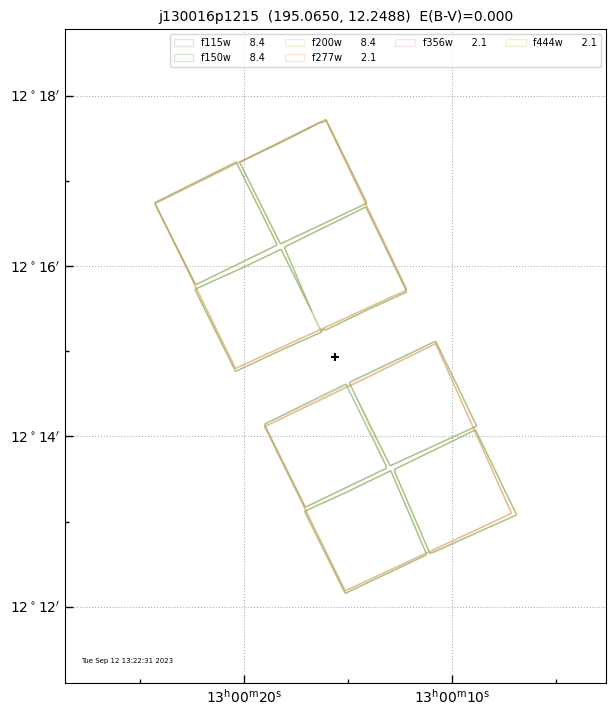

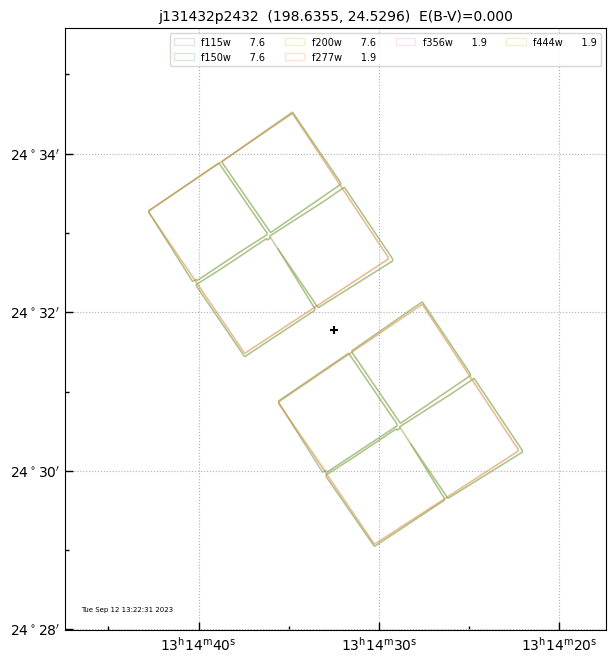

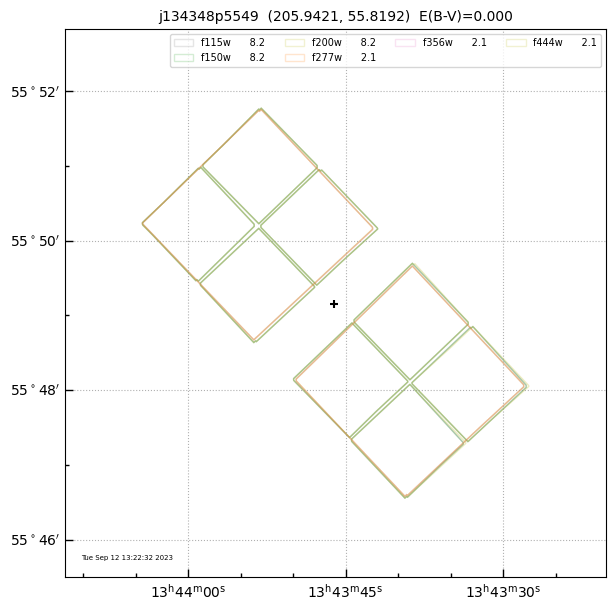

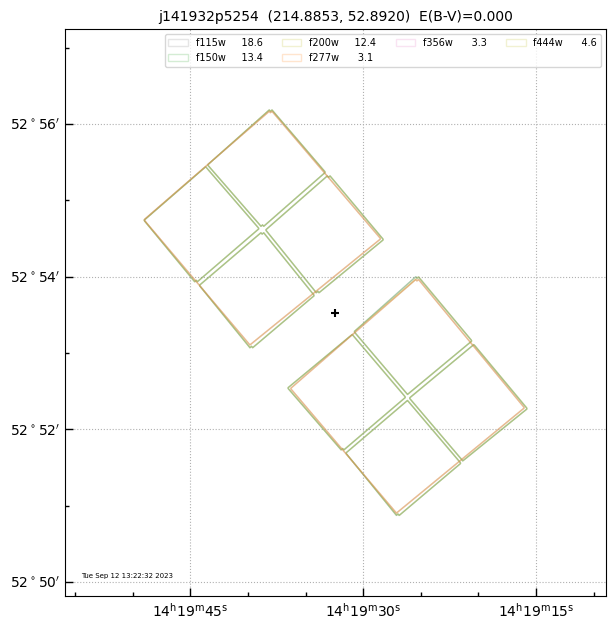

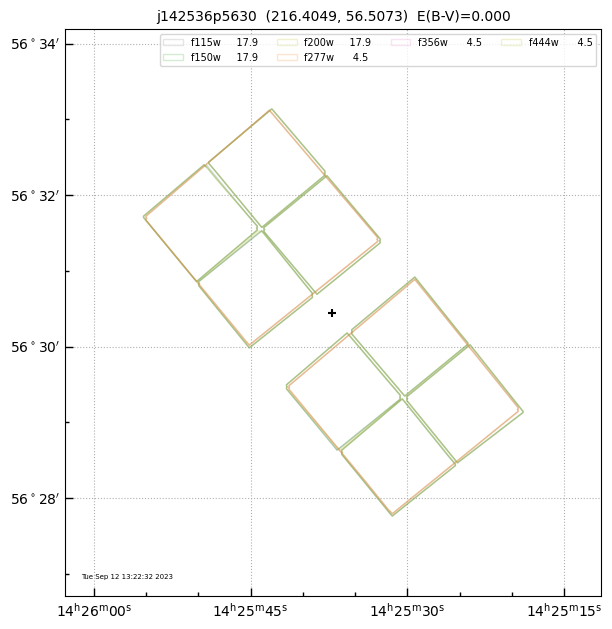

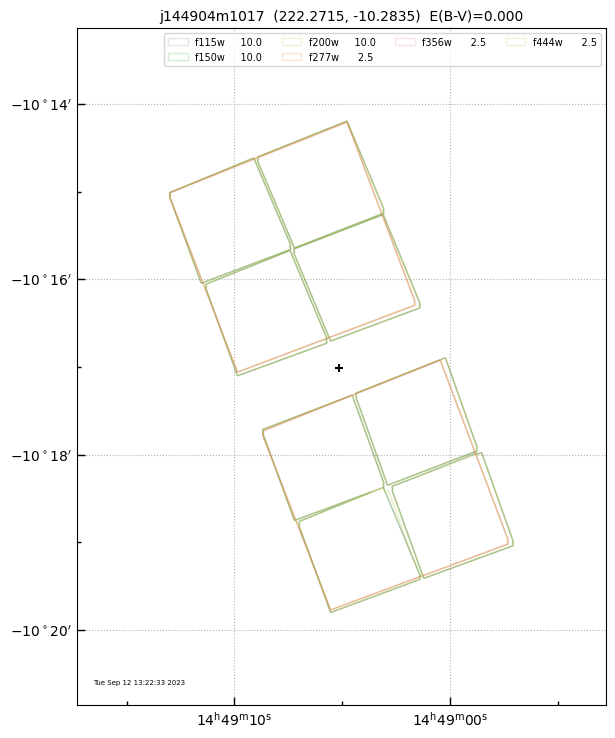

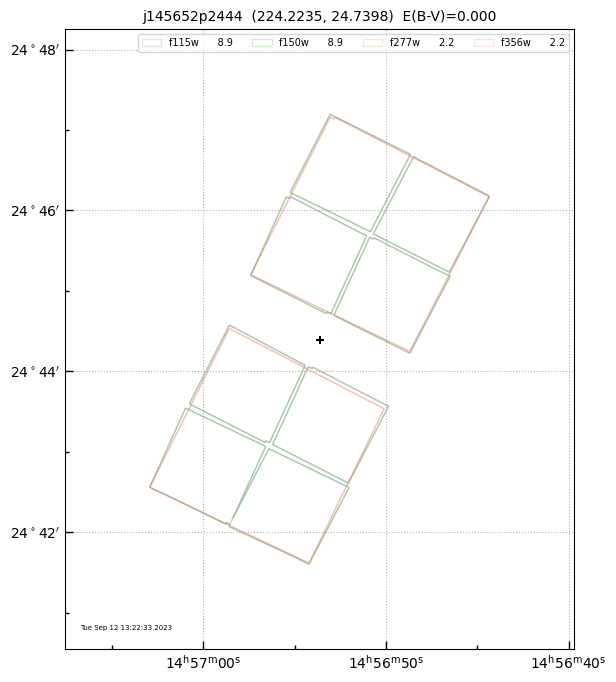

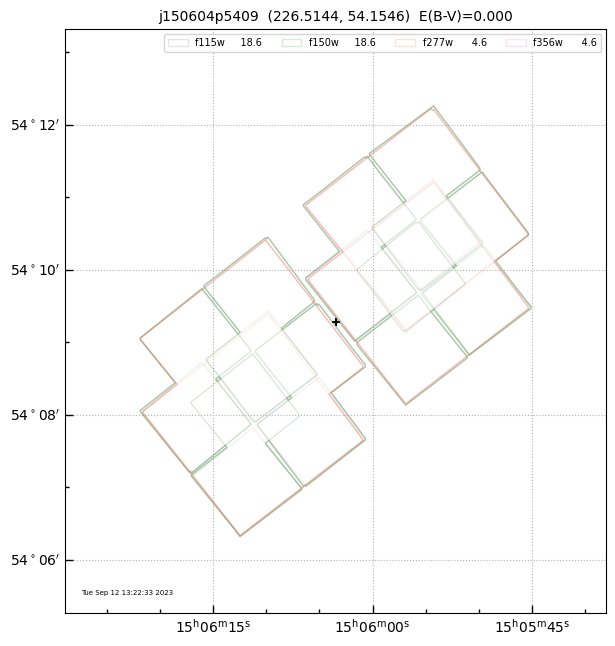

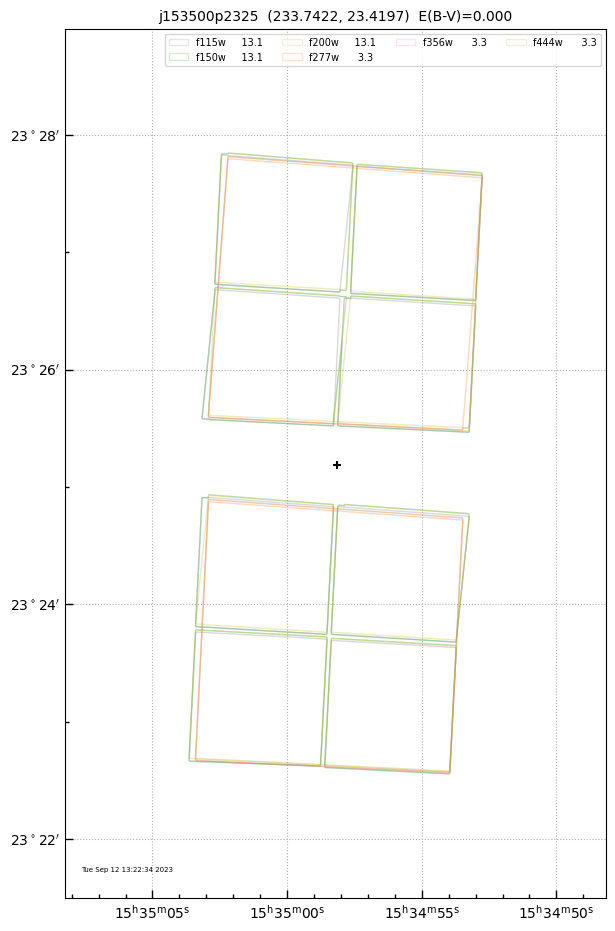

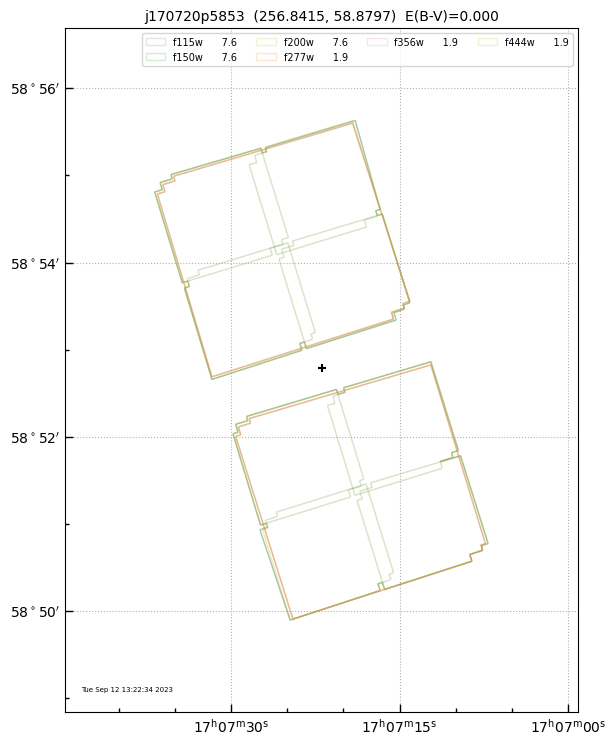

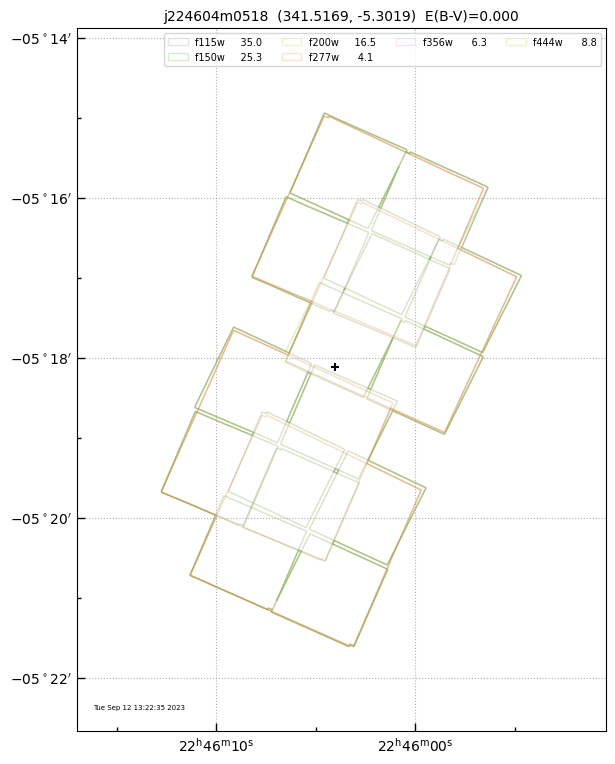

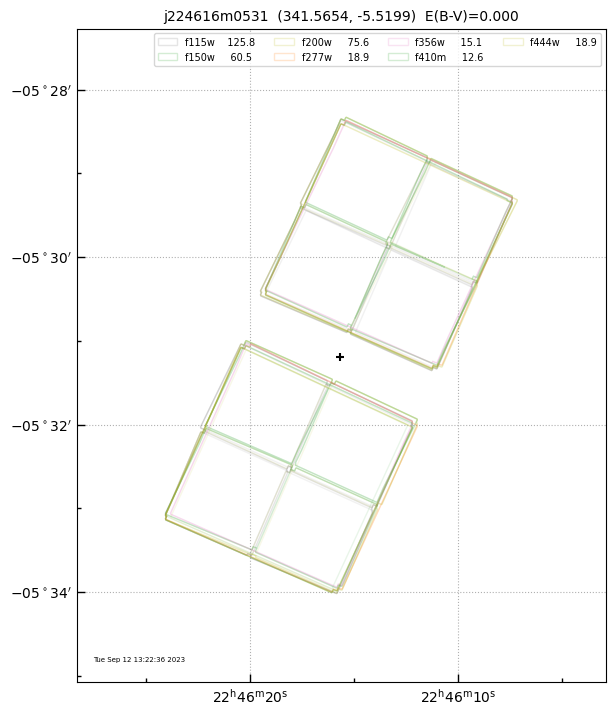

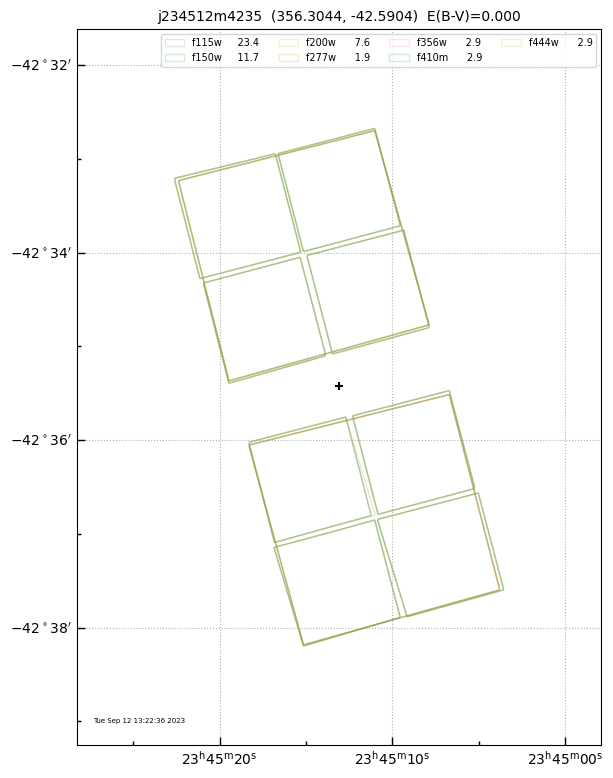

In [12]:
row = '# field        n   sx    sy   ra         dec         nx  ny  date       time'
with open('panoramic_fields.txt','w') as fp:
    fp.write(row+'\n')

print(row)

for field in un.values:
    rf = res[un[field]]
    
    # Things needed for the plot script
    rf.meta['NAME'] = field
    rf.meta['RA'] = np.mean(rf['ra'])
    rf.meta['DEC'] = np.mean(rf['dec'])
    rf.meta['MW_EBV'] = 0.0
    
    rf['obs_id'] = rf['dataset']
    rf['proposal_id'] = [int(d[3:7]) for d in rf['dataset']]
    rf['t_max'] = rf['t_min'] + rf['exptime']/86400.
    rf['instrument_name'] = rf['instrume']
    rf['target'] = 'indef'
    rf['filter'] = [f.split('-')[0] for f in rf['filter']]
    rf['footprint'] = [f'POLYGON {f.replace("(","").replace(")","").replace(","," ")}'
                       for f in rf['coords']]

    _ = overlaps.split_associations(rf, assoc_min=0, 
                                        #assoc_args=assoc_args,
                                        force_split=True,
                                        with_ls_thumbnail=False,
                                        xsize=6,
                                        )
                                        #ls_args=LS_ARGS)
    
    tab = _[0]
    fig = _[1]
    fig.savefig(f'panoramic-{field}.png')
    
    # size: the plot window is a box containing the exposures padded by 1arcmin
    cosd = np.cos(rf.meta['DEC']/180*np.pi)
    sx = (rf.meta['XMAX'] - rf.meta['XMIN'])*cosd*60-1
    sy = (rf.meta['YMAX'] - rf.meta['YMIN'])*60-1
    
    # Center of the plot as center ra/dec
    ra0 = (rf.meta['XMAX'] + rf.meta['XMIN'])/2.
    de0 = (rf.meta['YMAX'] + rf.meta['YMIN'])/2.
    
    # Size in units of 2048 x 40mas/pixel 
    nx = int(np.ceil(sx/(2048*0.04/60)))
    ny = int(np.ceil(sy/(2048*0.04/60)))

    tmax = astropy.time.Time(rf['t_max'].max(), format='mjd').iso

    row = f"{field:12} {un[field].sum():>3} {sx:5.1f} {sy:5.1f} {ra0:10.6f}  {de0:10.6f} {nx:>2}  {ny:>2}  {tmax}"
    if 1:
        with open('panoramic_fields.txt','a') as fp:
            fp.write(row+'\n')

    print(row)

## Run mosaics, catalogs

In [10]:
# Set version

mosaic_version = 'v6.0' # latest grizli (May 2023)

In [11]:
os.path.exists('/workspaces/panoramic-jwst')

True

In [12]:
# Work in /scratch on the root filesystem if expect to make more than 5 GB of files.
# NB: files here won't be saved when the machine is shut down!

# hmm, but doesn't seem to work
if 0:
    work_path = '/scratch'
    if not os.path.exists(work_path):
        os.makedirs(work_path)
elif os.path.exists('/workspaces/panoramic-jwst'):
    work_path = '/workspaces/panoramic-jwst/Mosaics'
else:
    work_path = '/work'

os.chdir(work_path)
print(f'Working directory: {work_path}')

! df -h . 

Working directory: /workspaces/panoramic-jwst/Mosaics
Filesystem      Size  Used Avail Use% Mounted on
/dev/loop3       32G   16G   14G  54% /workspaces


In [13]:
fields = utils.read_catalog('panoramic_fields.txt')
so = np.argsort(fields['date'])

fields[so].to_pandas()

,field,n,sx,sy,ra,dec,nx,ny,date,time
0,j170720p5853,120,4.9,6.9,256.841500,58.879350,4,6,2023-02-18,00:03:56.209
1,j153500p2325,240,3.6,6.4,233.742500,23.420000,3,5,2023-03-06,09:39:23.999
2,j145652p2444,40,5.3,6.7,224.223500,24.740000,4,5,2023-03-24,02:33:18.312
3,j123800p6217,432,17.0,15.7,189.485500,62.249400,13,12,2023-03-28,07:25:57.468
4,j125652p5652,240,6.4,3.8,194.211500,56.865700,5,3,2023-04-01,19:15:23.999
5,j150604p5409,160,6.5,7.1,226.514500,54.154800,5,6,2023-04-03,14:28:49.893
6,j090000p0207,80,4.0,6.5,135.004000,2.114070,3,5,2023-04-03,09:42:05.050
7,j093452p6116,80,5.9,6.5,143.708500,61.272400,5,5,2023-04-06,19:16:17.682
8,j094232p0923,120,4.9,6.7,145.630000,9.378995,4,5,2023-04-19,09:41:11.366
9,j093144p0819,120,4.7,6.7,142.941000,8.325030,4,5,2023-04-20,04:53:11.366


In [14]:
field_to_run = 'j013444m1532'

In [15]:
# Make a mosaic

LW_FILTERS = ['F277W-CLEAR','F356W-CLEAR','F444W-CLEAR',
              'F335M-CLEAR','F410M-CLEAR','F460M-CLEAR','F480M-CLEAR']

SW_FILTERS = ['F070W-CLEAR','F090W-CLEAR', 'F115W-CLEAR',
              'F150W-CLEAR','F200W-CLEAR', 'F210M-CLEAR' ]

WFC3IR_FILTERS = ['F160W','F140W','F125W','F110W','F105W','F098M']

ACS_FILTERS = ['F850LP','F814W','F606W','F435W','F438W','F775W']

for field in [field_to_run]:

    ix = np.where(fields['field'] == field)[0][0]

    pixel_scale = 0.04 # arcsec/pix

    hdu = utils.make_wcsheader(fields['ra'][ix], fields['dec'][ix],
                               size=(fields['nx'][ix]*2048*pixel_scale,
                                     fields['ny'][ix]*2048*pixel_scale),
                               pixscale=0.04, get_hdu=True)

    
    ir_wcs = pywcs.WCS(hdu.header)
    
    # Pull files from AWS and drizzle into a mosaic
    # NB: this will pull *any* exposure that overlaps with the defined WCS, 
    #     not just PANORAMIC from the query above. 

    root = f'panoramic-{field}-{mosaic_version}'
    for filt in LW_FILTERS:
        _ = visit_processor.cutout_mosaic(rootname=root,
                                      ir_wcs=ir_wcs,
                                      clean_flt=True,
                                      filters=[filt],
                                      half_optical=False,
                                      s3output=None,
                                      pixfrac=0.75,
                                      kernel='square',
                                      skip_existing=True,
                                      )
        gc.collect()
        # ! gzip {root}*{filt.lower()}*fits

    # SW run in a slightly weird way for memory issues?
    for filt in SW_FILTERS:
        _ = visit_processor.cutout_mosaic(rootname=root,
                                      ir_wcs=ir_wcs,
                                      clean_flt=True,
                                      filters=[filt],
                                      half_optical=True,
                                      s3output=None,
                                      pixfrac=0.75,
                                      kernel='square',
                                      skip_existing=True,
                                      )
        gc.collect()
        ! gzip {root}*{filt.lower()}*fits

    # HST at 40mas, just in case
    for filt in WFC3IR_FILTERS + ACS_FILTERS:
        _ = visit_processor.cutout_mosaic(rootname=root,
                                      ir_wcs=ir_wcs,
                                      clean_flt=True,
                                      filters=[filt],
                                      half_optical=False,
                                      s3output=None,
                                      pixfrac=0.75,
                                      kernel='square',
                                      skip_existing=True,
                                      )


============ panoramic-j013444m1532-v6.0-f277w-clear============

(   1/   8) Add exposure jw02514199001_06201_00001_nrcalong_rate.fits (weight_type='err', rnoise_percentile=99)

  (fetch from s3://grizli-v2/HST/Pipeline/j013444m1532_indef-f277w_00025/Prep/jw02514199001_06201_00001_nrcalong_rate.fits)
Use extra badpix in /usr/local/python/3.10.8/lib/python3.10/site-packages/grizli/data/nrc_badpix_20230710_NRCALONG.fits.gz
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 2085  ( 0.05 %)
get_photom_scale /usr/local/python/3.10.8/lib/python3.10/site-packages/grizli/data/photom_correction.yml: Scale NRCALONG-F277W-CLEAR by 0.942
  0    PHOTFLAM=3.66e-21, scale=0.942
       PHOTFLAM=3.66e-21, scale=0.942
  ext (SCI,1), sky=0.114 has_bkg:True median_weight:4.36e+03


The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can 

### RGB image

In [16]:
# RGB mosaic
def make_rgb(root, full_dimensions=2, scl=2.0):
    """
    Make RGB image
    """

    files = glob.glob(f"{root}*-f*clear*sci.fits*")
    files.sort()    

    filters = [f.split('-')[-2] + '-clear' for f in files]
    filters.sort()
    print(filters)

    auto_script.IMSAVE_QUALITY = 99

    norm = {'stretch': 'asinh', 'min_cut': -0.01, 
                                            'max_cut': 5.0, 'clip':True, 
                                            'asinh_a':0.010}

    im = pyfits.open(files[-1])

    msk = im[0].data != 0
    yp , xp = np.indices(msk.shape)
    spad = 64
    xyslice = (slice(np.maximum(xp[msk].min()-spad, 0), xp[msk].max()+spad), 
                slice(np.maximum(yp[msk].min()-spad, 0), yp[msk].max()+spad))

    print('slice: ', xyslice)

    filts = ['f356w-clear','f150w-clear','f115w-clear']
    rgb_scl = [1.0, 0.95, 1.02]

    if 'f444w-clear' in filters:
        filts = ['f444w-clear','f277w-clear','f115w-clear']

    rgb = auto_script.field_rgb(root,
                            HOME_PATH=None, gzext='*', 
                            filters=filts,
                            force_rgb=filts,
                            rgb_scl=rgb_scl,
                            full_dimensions=full_dimensions,
                            scl=scl,
                            suffix='.rgb',
                            xsize=128,
                            xyslice=xyslice,
                            add_labels=False,
                            norm_kwargs=norm,
                            output_format='png',
                            fill_black=True,
                            pl=2.0, pf=1)

    plt.close('all')    

In [17]:
if False: # Not enough memory on GitHub/codespace
    if (not os.path.exists(f'{root}.rgb.png')):
        make_rgb(root, full_dimensions=2, scl=2.0)
    else:
        print('RGB image found')
else:
    print('Not making RGB images....')


Not making RGB images....


### Detection image and catalog

LW detection image weighted by constant Fnu

Photometric catalog tends to run out of disk space...


In [18]:
from grizli.pipeline import auto_script
from grizli import prep
import astropy.io.fits as pyfits

comb = {'ir':['F444W-CLEAR','F356W-CLEAR','F277W-CLEAR',
              'F430M-CLEAR','F460M-CLEAR','F480M-CLEAR', 
              'CLEARP-F277W','CLEARP-F356W', 'CLEARP-F444W']}

block_filters = ['F090W-CLEAR','F115W-CLEAR','F150W-CLEAR','F200W-CLEAR']

# Not enough memory on GitHub/codespace?
MAKE_CATALOG = False

for field in fields['field']:
    root = f'panoramic-{field}-{mosaic_version}'

    files = glob.glob(f'{root}*sci.fits*')
    if len(files) == 0:
        continue
    
    if len(glob.glob(f'{root}-ir_drc_sci.fits*')) == 0:
        status = auto_script.make_filter_combinations(root,
                                                  filter_combinations=comb, 
                                                  weight_fnu=2, 
                                                  force_photfnu=1.e-8,
                                                  block_filters=block_filters
                                                 )
    
    # Make the photometric catalog
    phot_apertures = prep.SEXTRACTOR_PHOT_APERTURES_ARCSEC[:4]
    
    # Skip catalogs for now, since they make "bkg" images that fill up the disk quota
    if (not os.path.exists(f'{root}_phot.fits')) & MAKE_CATALOG:
        try:
            auto_script.multiband_catalog(field_root=root, 
                                      threshold=1.2, 
                                      bkg_params={'bw': 50, 'bh': 50,
                                                  'fw': 3, 'fh': 3,
                                                  'pixel_scale': pixel_scale}, 
                                      get_all_filters=True,
                                      phot_err_scale=1.0, 
                                      phot_apertures=phot_apertures,
                                      )
    
            phot = utils.read_catalog(f'{root}_phot.fits')
        except OSError:
            pass

        ! rm {root}*bkg.fits
        ! gzip {root}*seg.fits

panoramic-j013444m1532-v6.0-f277w-clear_drc_sci.fits f277w-clear ir block_reduce=False scl=1.0 scl_wht=1.0
panoramic-j013444m1532-v6.0-f356w-clear_drc_sci.fits f356w-clear ir block_reduce=False scl=1.0 scl_wht=1.0
panoramic-j013444m1532-v6.0-f444w-clear_drc_sci.fits f444w-clear ir block_reduce=False scl=1.0 scl_wht=1.0
Write panoramic-j013444m1532-v6.0-ir_drc_sci.fits


### Sync to S3

In [19]:
import astropy.time

for field in fields['field']:
    root = f'panoramic-{field}-{mosaic_version}'

    files = glob.glob(f'{root}*sci.fits*')
    if len(files) == 0:
        continue

    # Upload to S3
    ! rm {root}*bkg.fits

    files = glob.glob(f'{root}*_dr*fits')
    files += glob.glob(f'{root}*seg.fits')
    files.sort()
    
    for file in files:
        print(f'gzip {file}')
        ! gzip {file}

    s3path = f's3://grizli-panoramic/mosaics/{mosaic_version}/{field}/'

    ! aws s3 sync ./ {s3path} --exclude "*" --include "{root}*gz" --include "{root}*csv" --include "{root}*phot.fits" --include "{root}*cat.fits" --include "*{field}*png" --acl public-read

    extra_html = f"<img src=panoramic-{field}.png height=400px> <img src={root}.rgb.png height=400px> \n<br>"

    filter_files = glob.glob(f'{root}*fp.png')
    filter_files.sort()
    for file in filter_files:
        extra_html += f"<img src={file} height=200px>\n"

    extra_html += "<pre>\n# filter  expstart  ndrizim  exptime\n"
    files = glob.glob(f'{root}-f*_dr*sci.fits.gz')
    files.sort()
    for file in files:
        with pyfits.open(file) as im:
            expfact = 1.
            if im[0].header['INSTRUME'] == 'NIRCAM':
                if im[0].header['DETECTOR'] in ['NRCALONG','NRCBLONG']:
                    expfact = 2
                else:
                    expfact = 8

            row = f"{im[0].header['FILTER']} {im[0].header['EXPSTART']:.2f}  {im[0].header['NDRIZIM']//expfact}  {im[0].header['EXPTIME']/expfact:.1f}"

            print(row)
            extra_html += row + '\n'

    extra_html += f"</pre>\n"

    create_s3_index(s3path, output_file="index.html", extra_html=extra_html, upload=True)
    
    # Add to log
    log = utils.read_catalog('mosaic_log.txt')
    done = (log['field'] == field) & (log['version'] == mosaic_version)
    if done.sum() == 0:
        print(f'Add {field} {mosaic_version} to log.')

        with open('mosaic_log.txt','a') as fp:
            fp.write(f'{field}  {mosaic_version}  {astropy.time.Time.now().iso}\n')
    


rm: cannot remove 'panoramic-j013444m1532-v6.0*bkg.fits': No such file or directory
gzip panoramic-j013444m1532-v6.0-f277w-clear_drc_sci.fits
gzip panoramic-j013444m1532-v6.0-f277w-clear_drc_wht.fits
gzip panoramic-j013444m1532-v6.0-f356w-clear_drc_sci.fits
gzip panoramic-j013444m1532-v6.0-f356w-clear_drc_wht.fits
gzip panoramic-j013444m1532-v6.0-f444w-clear_drc_sci.fits
gzip panoramic-j013444m1532-v6.0-f444w-clear_drc_wht.fits
gzip panoramic-j013444m1532-v6.0-ir_drc_sci.fits
gzip panoramic-j013444m1532-v6.0-ir_drc_wht.fits
upload: ./panoramic-j013444m1532-v6.0-f115w-clear_wcs.csv to s3://grizli-panoramic/mosaics/v6.0/j013444m1532/panoramic-j013444m1532-v6.0-f115w-clear_wcs.csv
upload: ./panoramic-j013444m1532-v6.0-f115w-clear_fp.png to s3://grizli-panoramic/mosaics/v6.0/j013444m1532/panoramic-j013444m1532-v6.0-f115w-clear_fp.png
upload: ./panoramic-j013444m1532-v6.0-f150w-clear_fp.png to s3://grizli-panoramic/mosaics/v6.0/j013444m1532/panoramic-j013444m1532-v6.0-f150w-clear_fp.png
upl

## Master HTML log for all processed mosaics

Don't delete `mosaic_log.txt` if clearing out files to make space!

In [10]:
! cat mosaic_log.txt

# field  version date time
j090000p0207  v6.0  2023-05-04 09:44:57.191
j145652p2444  v6.0  2023-05-04 10:37:56.604
j093144p0819  v6.0  2023-05-04 11:16:46.528
j100736p2109  v6.0  2023-05-10 16:07:03.162
j093452p6116  v6.0  2023-05-10 18:43:31.732
j125652p5652  v6.0  2023-05-10 18:44:39.470
j150604p5409  v6.0  2023-05-10 19:45:12.123
j170720p5853  v6.0  2023-05-10 20:00:33.283
j094232p0923  v6.0  2023-05-10 20:12:52.988
j153500p2325  v6.0  2023-05-10 22:13:33.482
j131432p2432  v6.0  2023-06-13 13:57:40.377
j134348p5549  v6.0  2023-06-13 14:20:56.488
j121932p0330  v6.0  2023-06-14 13:06:03.030
j142536p5630  v6.0  2023-06-29 19:20:17.000
j130016p1215  v6.0  2023-06-29 20:56:29.000
j144904m1017  v6.0  2023-07-04 17:49:08.950
j123140m1618  v6.0  2023-07-04 18:35:28.420 
j000352m1120  v6.0  2023-07-19 21:19:40.026
j043844m6849  v6.0  2023-08-01 17:44:07.158
j021824m0517  v6.0  2023-08-01 18:12:07.183
j234512m4235  v6.0  2023-08-01 21:22:38.265
j010408m5508  v6.0  2023-08-07 22:03:14.504
j021

In [21]:

log = utils.read_catalog('mosaic_log.txt')

un = utils.Unique(log['version'])

with open('mosaics.html','w') as fp:
    for v in un.values:
        fp.write(f'<h3> Version {v} </h3>\n')

        for i in np.where(un[v])[0]:
            s3 = f"https://s3.amazonaws.com/grizli-panoramic/mosaics/{v}/{log['field'][i]}/index.html"
            fp.write(f"{log['date'][i]} {log['time'][i]} <a href=\"{s3}\" /> {log['field'][i]} </a> <br> \n")

    fp.write(f'<h3> Fields </h3>\n')
    for field in fields['field']:
        fp.write(f'<p> {field} </p> <img src=panoramic-{field}.png height=300px /> \n')

! aws s3 sync ./ s3://grizli-panoramic/mosaics/ --exclude "*" --include "mosaics.html" --include "panoramic*png" --exclude "*fp.png" --acl public-read



   N  value     
====  ==========
  27  v6.0      
upload: ./mosaics.html to s3://grizli-panoramic/mosaics/mosaics.html               
upload: ./panoramic-j094232p0923.png to s3://grizli-panoramic/mosaics/panoramic-j094232p0923.png
upload: ./panoramic-j021728m0214.png to s3://grizli-panoramic/mosaics/panoramic-j021728m0214.png
upload: ./panoramic-j000352m1120.png to s3://grizli-panoramic/mosaics/panoramic-j000352m1120.png
upload: ./panoramic-j010408m5508.png to s3://grizli-panoramic/mosaics/panoramic-j010408m5508.png
upload: ./panoramic-j090000p0207.png to s3://grizli-panoramic/mosaics/panoramic-j090000p0207.png
upload: ./panoramic-j093144p0819.png to s3://grizli-panoramic/mosaics/panoramic-j093144p0819.png
upload: ./panoramic-j013444m1532.png to s3://grizli-panoramic/mosaics/panoramic-j013444m1532.png
upload: ./panoramic-j093452p6116.png to s3://grizli-panoramic/mosaics/panoramic-j093452p6116.png
upload: ./panoramic-j043844m6849.png to s3://grizli-panoramic/mosaics/panoramic-j043844m6

In [22]:
!df -h . 

Filesystem      Size  Used Avail Use% Mounted on
/dev/loop3       32G   19G   12G  61% /workspaces


# Summary HTML hosted on github pages

Make a markdown file that will be rendered at https://gbrammer.github.io/panoramic-jwst/Mosaics/summary

In [42]:
from grizli.aws import db
full = db.SQL("""select assoc, crval1 as ra, crval2 as dec, dataset, filter, detector, exptime, expstart from exposure_files
where dataset like 'jw02514%%'
order by assoc, filter""")

full['parent'] = [a.split('_')[0] for a in full['assoc']]
       
# Split double field j224612m0527
test = full['parent'] == 'j224612m0527'
south = (full['dec'] < -5.4)
print((test & south).sum(), (test & ~south).sum())

parent = full['parent'].tolist()

for i in np.where(test & south)[0]:
    parent[i]= utils.radec_to_targname(full['ra'][test & south].mean(), full['dec'][test & south].mean())
for i in np.where(test & ~south)[0]:
    parent[i]= utils.radec_to_targname(full['ra'][test & ~south].mean(), full['dec'][test & ~south].mean())
    
full['parent'] = parent

# Merge MACS0416
dr = np.sqrt((full['ra']-64.061150)**2 +  (full['dec'] + 24.144900)**2)
macs0416 = dr < 0.4
if macs0416.sum() >  0:
    print(f"Merge {np.unique(full['parent'][macs0416]).tolist()} > 'j041616m2409'")
    full['parent'][macs0416] = 'j041616m2409'

len(full)

430 180
Merge ['j041616m2409', 'j041624m2411'] > 'j041616m2409'


5365

In [43]:
from grizli import utils
import numpy as np
import astropy.time
import time

# utils.Unique(full['filter'])
filters = np.unique(full['filter'])

with open('../Mosaics/summary.md','w') as fp:
    
    fp.write(f"""
![Alt text](../PanoramicLogo.png?raw=true "PanoramicLogo")

PANORAMIC Fields
----------------

- Exposure times in ks
- [Visit Status](https://www.stsci.edu/cgi-bin/get-visit-status?id=2514&markupFormat=html&observatory=JWST)

""")
    
    header    = '| field        | RA,Dec             | Note   | Date       '
    separator = '| :----------: | :----------------: | :----: | ----------:'
    for f in filters:
        header += f"| {f.split('-')[0]}  "
        separator += '|-------:'

    header += '|'
    separator += '|'
    print(header + '\n' + separator)

    fp.write(header + '\n' + separator + '\n')
    
    # prefix = [a.split('_')[0] for a in full['assoc']]
    # fields = utils.Unique(prefix, verbose=False)
    fields = utils.Unique(full['parent'], verbose=False)

    for fi in fields.values:
        fx = fields[fi]
        mjd = full['expstart'][fx].mean()
        iso = astropy.time.Time(mjd, format='mjd').iso.split()[0]

        row = f"| [{fi}](https://s3.amazonaws.com/grizli-panoramic/mosaics/v6.0/{fi}/index.html) "
        
        ra_map = full['crval1'][fx].mean()
        dec_map = full['crval2'][fx].mean()

        note_text = ''

        if fi == 'j224604m0518':
            MAPURL = "https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/panoramic-j224612m0527/index.html?coord=341.517,-5.302"
            
        elif fi == 'j224616m0531':
            MAPURL = "https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/panoramic-j224612m0527/index.html?coord=341.565,-5.520"
            
        elif fi == 'j141932p5254':
            MAPURL = f"https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/egs-v2/index.html?coord={ra_map:.3f},{dec_map:.3f}"
            note_text = 'EGS'
            
        elif fi.startswith('j123') & ('p62' in fi):
            # elif fi == 'j123800p6217':
            MAPURL = "https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/gdn/jwst.html?coord=189.3994832,62.2906066"
            note_text = 'GDN'
            
        elif fi in ('j033236m2755'):
            note_text = 'GDS'
            MAPURL = f"https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/panoramic-{fi}/index.html?coord={ra_map:.3f},{dec_map:.3f}"
            
        elif fi == 'j021728m0214':
            note_text = 'XMM/UDS'
            MAPURL = f"https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/panoramic-{fi}/index.html?coord={ra_map:.3f},{dec_map:.3f}"
            
        elif fi in ['j021824m0517','j021744m0518']:
            MAPURL = f"https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/uds/index.html?coord={ra_map:.3f},{dec_map:.3f}"
            note_text = 'UDS'
            
        elif fi.startswith('j0416'):
            note_text = 'MACS0416'
            MAPURL = f"https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/panoramic-{fi}/index.html?coord={ra_map:.3f},{dec_map:.3f}"
            
        elif fi in ['j024000m0142']:
            note_text = 'Abell370'
            MAPURL = f"https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/panoramic-{fi}/index.html?coord={ra_map:.3f},{dec_map:.3f}"
            
        else:
            MAPURL = f"https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/panoramic-{fi}/index.html?coord={ra_map:.3f},{dec_map:.3f}"
        
        row += f"| [{ra_map:8.3f}, {dec_map:8.3f}]({MAPURL}) | {note_text} | {iso} "

        for f in filters:
            nf = 8 if f < 'F250' else 2
            fx = fields[fi] & (full['filter'] == f)
            if fx.sum() > 0:
                row += f"| {full['exptime'][fx].sum()//nf/1000.:5.1f}  "
            else:
                row += f'| {" ":>5}  '


        row += '|'
        print(row)
        fp.write(row+'\n')
        


| field        | RA,Dec             | Note   | Date       | F115W  | F150W  | F200W  | F277W  | F356W  | F410M  | F444W  |
| :----------: | :----------------: | :----: | ----------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|


KeyError: 'crval1'

## Cleanup

In [25]:
! rm panoramic*fits* panoramic*fp.png panoramic*wcs.csv panoramic*rgb.png

rm: cannot remove 'panoramic*rgb.png': No such file or directory


# Generate drizzled cutout thumbnails on AWS Lambda

The cutout server uses pre-drizzled thumbnails generated on an all sky grid.  The code below runs the thumbnail generation for the little tile images that need to be generated.

For example:

http://grizli-cutout.herokuapp.com/thumb?all_filters=True&size=4&scl=1&asinh=True&filters=f814w,f115w-clear,f150w-clear,f200w-clear,f277w-clear,f335w-clear,f356w-clear,f410m-clear,f444w-clear&rgb_scl=1.5,0.74,1.3&pl=2&ra=53.1951458&dec=-27.7537779

In [36]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt

import mastquery

from grizli.aws.tile_mosaic import (drizzle_tile_subregion, reset_locked,
                    get_lambda_client, send_event_lambda, count_locked, tile_subregion_wcs)

from grizli.aws import db
from grizli import utils

client = get_lambda_client()
progs = ''
nt0 = 0

# cutout tiles that need to be drizzled
tiles = db.SQL(f"""SELECT tile, subx, suby, filter, count(filter) as count,
            min(substr(e.file,1,7)) as file0, max(substr(e.file,1,7)) as file1
            FROM mosaic_tiles_exposures t, exposure_files e
            WHERE t.expid = e.eid AND in_mosaic = 0
            {progs}
            AND filter < 'G0'
            GROUP BY tile, subx, suby, filter
            ORDER BY filter ASC
            """)

timeout = 60

len(tiles)

0

In [14]:
# Send to lambda
nt1 = len(tiles)
print(nt1, nt0-nt1)

NMAX = len(tiles)

istart = i = -1

max_locked = 800

step = max_locked - count_locked()[0]

while i < NMAX-1:
    i+=1 
    # if tiles['tile'][i] == 1183:
    #     continue
    
    if i-istart == step:
        istart = i
        print(f'\n ############### \n {time.ctime()}: Pause for {timeout} s  / {step} run previously')
        time.sleep(timeout)
        
        step = np.maximum(max_locked - count_locked()[0], 1)
        print(f'{time.ctime()}: Run {step} more \n ############## \n')
                
    event = dict(tile=int(tiles['tile'][i]), 
                    subx=int(tiles['subx'][i]),
                    suby=int(tiles['suby'][i]),
                    filter=tiles['filter'][i], 
                    exposure_count=int(tiles['count'][i]),
                    counter=i+2, 
                    time=time.ctime())
    
    if 1:
        send_event_lambda(event, client=client, func='grizli-redshift-fit')


700 -700
Send event to grizli-redshift-fit: {'tile': 217, 'subx': 295, 'suby': 173, 'filter': 'F090W-CLEAR', 'exposure_count': 4, 'counter': 2, 'time': 'Sat Sep  9 21:01:15 2023'}
Send event to grizli-redshift-fit: {'tile': 217, 'subx': 295, 'suby': 174, 'filter': 'F090W-CLEAR', 'exposure_count': 2, 'counter': 3, 'time': 'Sat Sep  9 21:01:15 2023'}
Send event to grizli-redshift-fit: {'tile': 217, 'subx': 296, 'suby': 172, 'filter': 'F090W-CLEAR', 'exposure_count': 2, 'counter': 4, 'time': 'Sat Sep  9 21:01:16 2023'}
Send event to grizli-redshift-fit: {'tile': 217, 'subx': 296, 'suby': 173, 'filter': 'F090W-CLEAR', 'exposure_count': 4, 'counter': 5, 'time': 'Sat Sep  9 21:01:16 2023'}
Send event to grizli-redshift-fit: {'tile': 217, 'subx': 296, 'suby': 174, 'filter': 'F090W-CLEAR', 'exposure_count': 4, 'counter': 6, 'time': 'Sat Sep  9 21:01:17 2023'}
Send event to grizli-redshift-fit: {'tile': 217, 'subx': 296, 'suby': 175, 'filter': 'F090W-CLEAR', 'exposure_count': 8, 'counter': 7, '

# Mosaic FITSMap tiling on S3

Define field tiles for the interactive FitsMap webpages

In [13]:
tile_fields = db.SQL("""select field, AVG(crval1) as ra, AVG(crval2) as dec, count(field) from combined_tiles
group by field
order by field
""")
tile_fields

field,ra,dec,count
str22,float64,float64,int64
abell2744,3.58750000,-30.39666670,225
abell370,39.97500000,-1.57527780,225
cos,150.12500000,2.20000000,1089
dracoii,238.19833330,64.56528000,64
egs,214.82880000,52.80673330,484
egs-v2,214.82880000,52.80673330,484
gdn,189.23690290,62.23128390,289
gds,53.15924640,-27.78282230,289
j010256m4914,15.69609258,-49.26215000,289


In [14]:
field_footprints = db.SQL("""select field, tile, footprint from combined_tiles""")
len(field_footprints)

15932

In [20]:
fields = utils.read_catalog('panoramic_fields.txt')
fields['parent'] = fields['field']
fields['field'] = [f'panoramic-{f}' for f in fields['field']]

so = np.argsort(fields['date'])

# Shift by half tile to put one NIRCam module in the center of a tile
xsh = 3.072/60./2.

fields['ra'] -= xsh/np.cos(fields['dec']/180*np.pi)
fields['dec'] -= xsh

fields[so]

field,n,sx,sy,ra,dec,nx,ny,date,time,parent
str22,int64,float64,float64,float64,float64,int64,int64,str10,str12,str12
panoramic-j170720p5853,120,4.9,6.9,256.7919684123834,58.853750000000005,4,6,2023-02-18,00:03:56.209,j170720p5853
panoramic-j153500p2325,240,3.6,6.4,233.71460161799536,23.3944,3,5,2023-03-06,09:39:23.999,j153500p2325
panoramic-j145652p2444,40,5.3,6.7,224.19531287984384,24.714399999999998,4,5,2023-03-24,02:33:18.312,j145652p2444
panoramic-j123816p6217,9,6.3,3.7,189.51496695096552,62.25285,5,3,2023-03-26,02:37:57.468,j123816p6217
panoramic-j123800p6217,432,17.0,15.7,189.43051999110227,62.223800000000004,13,12,2023-03-28,07:25:57.468,j123800p6217
panoramic-j125652p5652,240,6.4,3.8,194.1646653081678,56.8401,5,3,2023-04-01,19:15:23.999,j125652p5652
panoramic-j150604p5409,160,6.5,7.1,226.47078395384054,54.129200000000004,5,6,2023-04-03,14:28:49.893,j150604p5409
panoramic-j090000p0207,80,4.0,6.5,134.97838256387973,2.08847,3,5,2023-04-03,09:42:05.050,j090000p0207
panoramic-j093452p6116,80,5.9,6.5,143.65523834493206,61.2468,5,5,2023-04-06,19:16:17.682,j093452p6116


In [22]:
# Look if panoramic fields already have tiles
coo = np.array([fields['ra'], fields['dec']]).T

fields['field'] = [f'panoramic-{f}' for f in fields['parent']]
# fields['field'] = [f'{f}' for f in fields['parent']]

fields['in_tile'] = False
for fi, fp in zip(field_footprints['field'], field_footprints['footprint']):
    sr = utils.SRegion(fp)
    in_i = sr.path[0].contains_points(coo)
    if in_i.sum() > 0:
        fields['field'][in_i] = fi
        fields['in_tile'] |= in_i
    
# Default 46 arcmin on a size to be big and to match
# center tile default of (9,9) in grizli.field_tiles.process_tile
fields['dx'] = fields['dy'] = 46
fields['rsize'] = fields['dx']/2

In [23]:
fields[so]

field,n,sx,sy,ra,dec,nx,ny,date,time,parent,in_tile,dx,dy,rsize
str22,int64,float64,float64,float64,float64,int64,int64,str10,str12,str12,bool,int64,int64,float64
panoramic-j170720p5853,120,4.9,6.9,256.7919684123834,58.853750000000005,4,6,2023-02-18,00:03:56.209,j170720p5853,True,46,46,23.0
panoramic-j153500p2325,240,3.6,6.4,233.71460161799536,23.3944,3,5,2023-03-06,09:39:23.999,j153500p2325,True,46,46,23.0
panoramic-j145652p2444,40,5.3,6.7,224.19531287984384,24.714399999999998,4,5,2023-03-24,02:33:18.312,j145652p2444,True,46,46,23.0
gdn,9,6.3,3.7,189.51496695096552,62.25285,5,3,2023-03-26,02:37:57.468,j123816p6217,True,46,46,23.0
gdn,432,17.0,15.7,189.43051999110227,62.223800000000004,13,12,2023-03-28,07:25:57.468,j123800p6217,True,46,46,23.0
panoramic-j125652p5652,240,6.4,3.8,194.1646653081678,56.8401,5,3,2023-04-01,19:15:23.999,j125652p5652,True,46,46,23.0
panoramic-j150604p5409,160,6.5,7.1,226.47078395384054,54.129200000000004,5,6,2023-04-03,14:28:49.893,j150604p5409,True,46,46,23.0
panoramic-j090000p0207,80,4.0,6.5,134.97838256387973,2.08847,3,5,2023-04-03,09:42:05.050,j090000p0207,True,46,46,23.0
panoramic-j093452p6116,80,5.9,6.5,143.65523834493206,61.2468,5,5,2023-04-06,19:16:17.682,j093452p6116,True,46,46,23.0


In [24]:
from grizli.aws.field_tiles import make_field_tiles

ix = so[-1]
tiles = make_field_tiles(**fields[ix], tile_npix=2048+256, pscale=0.08, initial_status=90, send_to_database=False)

# CRPIX1, CRPIX2 should be 1152,1152 for tile '09.09'
ii = tiles['tile'] == '09.09'
tiles[ii]

abell370: tile size, arcmin = 3.072


tile,wcsaxes,crpix1,crpix2,cd1_1,cd2_2,cdelt1,cdelt2,cunit1,cunit2,ctype1,ctype2,crval1,crval2,lonpole,latpole,mjdref,radesys,naxis,naxis1,naxis2,footprint,status,field
str5,int64,float64,float64,float64,float64,float64,float64,str3,str3,str8,str8,float64,float64,float64,float64,float64,str4,int64,int64,int64,str89,int64,str8
09.09,2,1152.0,1152.0,-2.2222222222222e-05,2.2222222222222e-05,1.0,1.0,deg,deg,RA---TAN,DEC--TAN,39.981638837698,-1.71727,180.0,-1.71727,0.0,ICRS,2,2304,2304,"((40.007240,-1.742859),(40.007239,-1.691681),(39.956039,-1.691681),(39.956038,-1.742859))",90,abell370


# Send to database

In [12]:
# if 0:
#     db.execute("delete from combined_tiles where field like 'panoramic%%'")

In [25]:
SEND_TO_DB = False

for ix in so: #range(len(fields)):
    if not fields['in_tile'][ix]:
        print(ix, fields[ix]['field'])
        if SEND_TO_DB:
            tiles = make_field_tiles(**fields[ix], tile_npix=2048+256, pscale=0.08,
                                 initial_status=90, send_to_database=True)
        else:
            print('Set SEND_TO_DB = True to send the new tile defs to the database')
            
    else:
        print(f"{ix:>3}: Tile field {fields['field'][ix]} found")

 32: Tile field panoramic-j170720p5853 found
 31: Tile field panoramic-j153500p2325 found
 29: Tile field panoramic-j145652p2444 found
 21: Tile field gdn found
 20: Tile field gdn found
 22: Tile field panoramic-j125652p5652 found
 30: Tile field panoramic-j150604p5409 found
 13: Tile field panoramic-j090000p0207 found
 15: Tile field panoramic-j093452p6116 found
 16: Tile field panoramic-j094232p0923 found
 14: Tile field panoramic-j093144p0819 found
 17: Tile field panoramic-j100736p2109 found
 25: Tile field panoramic-j134348p5549 found
 24: Tile field panoramic-j131432p2432 found
 18: Tile field panoramic-j121932p0330 found
 27: Tile field panoramic-j142536p5630 found
 23: Tile field panoramic-j130016p1215 found
 26: Tile field egs found
 28: Tile field panoramic-j144904m1017 found
 19: Tile field panoramic-j123140m1618 found
  0: Tile field panoramic-j000352m1120 found
 34: Tile field panoramic-j224612m0527 found
 33: Tile field panoramic-j224612m0527 found
  8: Tile field uds fo

# Generate drizzled tiles on EC2

**Update (13 Jun 2023):** Do this in `Notebooks/step4-make-map-tiles.ipynb`